# Access ERA5 data from glade and plot temp anomaly for Colorado

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import intake_esm
import intake
import pandas as pd
import cartopy.crs as ccrs  # Correct import for coordinate reference systems
import cartopy.feature as cfeature
from holoviews import opts
import geoviews as gv
import holoviews as hv

In [2]:
import dask
from dask.distributed import Client, performance_report
from dask_jobqueue import PBSCluster

### Specify global variables

In [3]:
lat = 40.014
lon =  -105.270 + 360
# Bounding box for Colorado
colorado_right  =  (-109.060253 + 360)%360
colorado_left   = (-102.041524 + 360)%360 
colorado_bottom = 37
colorado_top    = 41
###
baseline_year = 1940
current_year  = 2023
day           = 11
month         = 6

In [4]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'

### Spin-up PBS Cluster

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-pythia-24',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch + '/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '1:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/work/harshah/conda-envs/zarr_experiments/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37475 instead
  warnings.warn(


In [6]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/37475/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/37475/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:35931,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/37475/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Scale the cluster

In [7]:
cluster.scale(2)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/37475/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:35931,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/37475/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Open ERA5 catalog 

In [8]:
era5_cat = intake.open_esm_datastore('/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/era5_catalog.json')
era5_cat

/glade/work/harshah/conda-envs/zarr_experiments/lib/python3.11/site-packages/intake_esm/cat.py:249: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,unique
era_id,1
datatype,2
level_type,1
step_type,7
table_code,4
param_code,164
variable,212
long_name,212
units,33
year,85


In [9]:
era5_df = era5_cat.df
era5_df.head()

,era_id,datatype,level_type,step_type,table_code,param_code,variable,long_name,units,year,month,format,frequency,path
0,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
1,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
2,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
3,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
4,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...


- Explore the list of variables to find the name of the 2m air temperature

In [10]:
era5_df['variable'].unique()

array(['PV', 'CRWC', 'CSWC', 'Z', 'T', 'U', 'V', 'Q', 'W', 'VO', 'D', 'R',
       'O3', 'CLWC', 'CIWC', 'CC', 'ALUVP', 'ALUVD', 'ALNIP', 'ALNID',
       'CI', 'ASN', 'RSN', 'SSTK', 'ISTL1', 'ISTL2', 'ISTL3', 'ISTL4',
       'SWVL1', 'SWVL2', 'SWVL3', 'SWVL4', 'CAPE', 'LAILV', 'LAIHV',
       'TCLW', 'TCIW', 'SP', 'TCW', 'TCWV', 'STL1', 'SD', 'CHNK', 'MSL',
       'BLH', 'TCC', 'VAR_10U', 'VAR_10V', 'VAR_2T', 'VAR_2D', 'STL2',
       'STL3', 'LCC', 'MCC', 'HCC', 'SRC', 'TCO3', 'IEWS', 'INSS', 'ISHF',
       'IE', 'SKT', 'STL4', 'TSN', 'FAL', 'FSR', 'FLSR', 'LBLT', 'LTLT',
       'LSHF', 'LICT', 'LICD', 'TCRW', 'TCSW', 'U10N', 'V10N', 'VAR_100U',
       'VAR_100V', 'LMLT', 'LMLD', 'VIMA', 'VIT', 'VIKE', 'VITHE',
       'VIPIE', 'VIPILE', 'VITOE', 'VIEC', 'VIMAE', 'VIMAN', 'VIKEE',
       'VIKEN', 'VITHEE', 'VITHEN', 'VIWVE', 'VIWVN', 'VIGE', 'VIGN',
       'VITOEE', 'VITOEN', 'VIOZE', 'VIOZN', 'VILWD', 'VIIWD', 'VIMAD',
       'VIKED', 'VITHED', 'VIWVD', 'VIGD', 'VITOED', 'VIOZD', 'VILWE

- We find that the variable of interest is called 'VAR_2T'

In [11]:
temp_cat = era5_cat.search(variable='VAR_2T',frequency = 'hourly')
temp_cat

,unique
era_id,1
datatype,1
level_type,0
step_type,1
table_code,1
param_code,1
variable,1
long_name,1
units,1
year,85


- Convert catalog to dictonary
- Inspect keys

In [12]:
dsets = temp_cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


In [13]:
dsets.keys()

dict_keys(['an.sfc'])

- Extract dataset using dictionary

In [14]:
temp_2m = dsets['an.sfc'].VAR_2T
temp_2m

<xarray.DataArray 'VAR_2T' (time: 737784, latitude: 721, longitude: 1440)> Size: 3TB
dask.array<concatenate, shape=(737784, 721, 1440), dtype=float32, chunksize=(27, 139, 277), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2024-02-29T23:00:00
    utc_date   (time) int32 3MB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    number_of_significant_digits:                       7
    QuantizeBitGroomNumberOfSignificantDigits:          7

- Select data corresponding to the dayofyear and colorado for the years baseline_year and current_year

In [15]:
# Create a pandas Timestamp
current_date  = pd.Timestamp(year=current_year, month=month, day=day)
baseline_date =  pd.Timestamp(year=baseline_year, month=month, day=day)
current_date

Timestamp('2023-06-11 00:00:00')

In [16]:
t2m_colorado_current = temp_2m.sel(latitude=slice(colorado_top,colorado_bottom),\
                                         longitude=slice(colorado_right,colorado_left)).sel(time=slice(current_date,current_date+  pd.Timedelta(days=1)))
t2m_colorado_current

<xarray.DataArray 'VAR_2T' (time: 25, latitude: 17, longitude: 28)> Size: 48kB
dask.array<getitem, shape=(25, 17, 28), dtype=float32, chunksize=(22, 17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8
  * time       (time) datetime64[ns] 200B 2023-06-11 ... 2023-06-12
    utc_date   (time) int32 100B dask.array<chunksize=(25,), meta=np.ndarray>
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    number_of_significant_digits:                       7
    QuantizeBitGroomNumberOfSignificantDigits:          7

In [17]:
t2m_colorado_baseline = temp_2m.sel(latitude=slice(colorado_top,colorado_bottom),\
                                         longitude=slice(colorado_right,colorado_left)).sel(time=slice(current_date,current_date+  pd.Timedelta(days=1)))
t2m_colorado_baseline

<xarray.DataArray 'VAR_2T' (time: 25, latitude: 17, longitude: 28)> Size: 48kB
dask.array<getitem, shape=(25, 17, 28), dtype=float32, chunksize=(22, 17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8
  * time       (time) datetime64[ns] 200B 2023-06-11 ... 2023-06-12
    utc_date   (time) int32 100B dask.array<chunksize=(25,), meta=np.ndarray>
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    number_of_significant_digits:                       7
    QuantizeBitGroomNumberOfSignificantDigits:          7

In [18]:
max_t2m_colorado_anomaly = t2m_colorado_current.max('time') - t2m_colorado_baseline.max('time')
max_t2m_colorado_anomaly

<xarray.DataArray 'VAR_2T' (latitude: 17, longitude: 28)> Size: 2kB
dask.array<sub, shape=(17, 28), dtype=float32, chunksize=(17, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 136B 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude  (longitude) float64 224B 251.0 251.2 251.5 ... 257.2 257.5 257.8

## Let us now plot this data with a map of Colorado in the background

In [20]:
# Extract the latitude, longitude, and data
latitude = max_t2m_colorado_anomaly['latitude'].values
longitude = max_t2m_colorado_anomaly['longitude'].values
max_t2m_colorado_anomaly = max_t2m_colorado_anomaly.data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
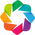

:Overlay
   .WMTS.I          :WMTS   [Longitude,Latitude]
   .Image.I         :Image   [Longitude,Latitude]   (value)
   .State_Borders.I :Feature   [Longitude,Latitude]
   .Borders.I       :Feature   [Longitude,Latitude]
   .States.I        :Feature   [Longitude,Latitude]

In [30]:
# Create the plot
proj = ccrs.PlateCarree(central_longitude=180)
tiles = gv.tile_sources.ESRI()

# Define the state borders feature
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none'
)

# Create a GeoViews plot
plot = gv.Image((longitude, latitude, max_t2m_colorado_anomaly), crs=proj, vdims='value').opts(
    cmap='viridis',
    colorbar=True,
    width=800,
    height=600
)

# Add state borders and other features
state_borders = gv.feature.Feature(states, group='State Borders').opts(line_color='black')
# borders = gv.feature.borders.opts(line_dash='dotted', zorder=2)
# state_lines = gv.feature.states.opts(line_color='black', zorder=3)
# borders = gv.feature.borders.opts(line_dash='dotted')
# state_lines = gv.feature.states.opts(line_color='black')

# Combine everything into a single plot
final_plot = tiles * plot * state_borders * borders * state_lines

# Display the plot
hv.extension('bokeh')
final_plot.opts(
    opts.Overlay(projection=ccrs.PlateCarree(central_longitude=180), global_extent=False),
    opts.Image(tools=['hover']),
    opts.Feature(line_width=1.5)
).opts(
    opts.GridSpace(show_title=True, shared_xaxis=True, shared_yaxis=True, height=400, width=600)
)

# To add grid lines with labels, use the options on the plot directly
final_plot.opts(
    opts.Image(xaxis='bottom', yaxis='left', show_grid=True)
)